# Setup

In [1]:
!conda info --envs

# conda environments:
#
base                     C:\DDRIVE\ProgramFiles\Anaconda3
wildfire              *  C:\DDRIVE\ProgramFiles\Anaconda3\envs\wildfire



In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import csv
import numpy as np
import os
import sqlite3
import copy
from dbfread import DBF
import geopandas as gpd
import fiona
import pprint
import folium
import descartes
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import features
import rasterio.mask
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import pickle
from scipy import stats
from rasterio.windows import Window
from numpy import nan
import seaborn as sns

print(f"Python Version = {sys.version}")
print(f"Pandas Version = {pd.__version__}")
print(f"Geopandas Version = {gpd.__version__}")
print(f"rasterio version = {rio._base.gdal_version()}")

Python Version = 3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 21:48:41) [MSC v.1916 64 bit (AMD64)]
Pandas Version = 1.0.1
Geopandas Version = 0.7.0
rasterio version = 3.0.4


# Definitions

1) Fine Fuel Moisture Code
The Fine Fuel Moisture Code (FFMC) is a numeric rating of the moisture content of litter and other cured fine fuels. This code is an indicator of the relative ease of ignition and the flammability of fine fuel.

2) Duff Moisture Code
The Duff Moisture Code (DMC) is a numeric rating of the average moisture content of loosely compacted organic layers of moderate depth. This code gives an indication of fuel consumption in moderate duff layers and medium-size woody material.

3) Drought Code
The Drought Code (DC) is a numeric rating of the average moisture content of deep, compact organic layers. This code is a useful indicator of seasonal drought effects on forest fuels and the amount of smoldering in deep duff layers and large logs.

4)  Initial Spread Index
The Initial Spread Index (ISI) is a numeric rating of the expected rate of fire spread. It combines the effects of wind and the FFMC on rate of spread without the influence of variable quantities of fuel.

https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi

5) Temp
Temperature in Celsius degrees

6) RH
Relative humidity in %

7) Wind
Wind speed in km/h

8) Rain
Outside rain in mm/m2

9) Area
The burned area of the forest (in ha), ha = hectare = 2.47 acres

10) X
x-axis spatial coordinate within the Montesinho park map: 1 to 9 2

11) Y
y-axis spatial coordinate within the Montesinho park map: 2 to 9 3

Literature:

https://news.uci.edu/2019/09/17/uci-team-uses-machine-learning-to-help-tell-which-wildfires-will-burn-out-of-control/

In the original paper (Portugal - Montesinho fires), the best result (predicting burned area) was only using the 4 weather conditions: RH/Wind/Rain/Temp, and an SVM.

This: https://datasetsearch.research.google.com/search?query=wildfire%20area&docid=fchFFzqh0O3qjX3PAAAAAA%3D%3D has georeferenced and date/time referenced with areas. Could combine with weather data for those dates/times.

# Query shape of datasets, type, feature names and how they work together

In [5]:
os.getcwd()

'C:\\DDRIVE\\W210 Capstone\\wildfireplus\\EDA'

## Fire Data  

In the 'Laura EDA-Geo_Env.ipynb' you can see all the global data. Here we  have only pulled the 2016 California data to do further EDA.

### PRJ file - CRS Descriptions

In [4]:
with open('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.prj') as f1:
    print(f"Ignitions Prj file contents = {f1.read()}")
    
with open('../data/GlobalFire2016/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.prj','r') as f2:
    print(f"Perimeter Prj file contents = {f2.read()}")    

Ignitions Prj file contents = GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]
Perimeter Prj file contents = GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]


The above mean:
- GEOGCS: Geographic coordinate reference system (vs. a projected coordinate system)
- WGS 84 : the name of the geographic coordinate reference system
- WGS_1984: The name of the DATUM
- SPHEROID: Used for the reference system with the semi major axis = 6378137 m and inverse-flattening ratio of 298.257223563
- PRIMEM: Greenwich is prime meridian where longitude is set as 0
- UNIT: measurement units of coordinate system, in degrees, where 0.01745.. is the conversion from radians to the units here(degrees)

### California - GEOTiffs and GPD Dataframes

Reimport and engineer the features appropriately

First, don't combine the shp files (as in 2.4.2.3). Instead, create 3 dataframes:  
1) fire ID and all the features (except geometry)  
2) fire ID and POLYGON  
3) fire ID and POINT (ignition)  

In [9]:
%%time
ign_gdf = gpd.read_file('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.shp')
poly_gdf = gpd.read_file('../data/GlobalFire2016/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.shp')

Wall time: 2min 19s


In [14]:
# Global Fire Atlas GEOTiff projection Coordinate Reference System (from website)
gfacrs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs" 

#### CA State Boundaries

From https://data.ca.gov/dataset/ca-geographic-boundaries/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b

In [10]:
%%time
CA_gdf = gpd.read_file('../data/ca-state-boundary/CA_state_TIGER2016.shp')

Wall time: 112 ms


In [11]:
CA_gdf

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,4,9,06,01779778,06,CA,California,00,G4000,A,403501101370,20466718403,+37.1551773,-119.5434183,"MULTIPOLYGON (((-13317677.375 3930590.808, -13..."


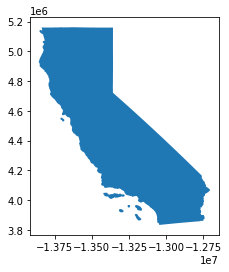

In [12]:
CA_gdf.plot()

#### Crop rasters to California

From Earth  data science: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/

In [ ]:
# Raster Data opened by rio is diryr
print(diryr.bounds)

In [288]:
# Crop extent: CA_gdf
print('crop extent crs = \n', CA_gdf.crs)
print('tiff crs = \n', diryr.crs)

crop extent crs = 
 {'init': 'epsg:3857'}
tiff crs = 
 PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [289]:
# Set destination CRS
dst_crs = CA_gdf.crs

In [290]:
%%time
# Calculate the transform using the rasterio warp function
transform,width,height = calculate_default_transform(diryr.crs,dst_crs,diryr.width,diryr.height,*diryr.bounds)

Wall time: 121 ms


In [291]:
%%time
# Set the new meta data for the projected raster file
kwargs = diryr.meta.copy()
kwargs.update({'crs':dst_crs,
              'transform':transform,
              'width':width,
              'height':height
              })

Wall time: 1 ms


In [292]:
%%time
# write the new raster file by using the rasterio reproject function
with rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016_reproj.tif','w',**kwargs) as dst:
    for i in range(1, diryr.count + 1):
        reproject(
            source = rio.band(diryr,i),
            destination=rio.band(dst,i),
            diryr_transform = diryr.transform,
            diryr_crs = diryr.crs,
            dst_transform = transform,
            dst_crs = dst_crs,
            resampling=Resampling.nearest)

Wall time: 10min 33s


In [295]:
%%time
# Open the new reprojected geotiff
diryr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016_reproj.tif')
print(diryr_reproj.meta)

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': -9999.0, 'width': 78580, 'height': 38174, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(509.9863732168427, 0.0, -20037508.33380717,
       0.0, -509.9928633270912, 11068715.657331526)}
Wall time: 43 ms


In [296]:
%%time
# Crop extent: CA_gdf - crop to the boundaries of California, which should work now that both raster 
# and shapefile are on the same CRS
print('crop extent crs = \n', CA_gdf.crs)
print('tiff crs = \n', diryr_reproj.crs)

crop extent crs = 
 {'init': 'epsg:3857'}
tiff crs = 
 EPSG:3857
Wall time: 1e+03 µs


In [297]:
%%time
# Use the earthpy.spatial function to crop the tif by the shapefile
diryr_reproj_crop, diryr_reproj_crop_meta = es.crop_image(diryr_reproj,CA_gdf)

Wall time: 2.16 s


In [298]:
print("cropped data", diryr_reproj_crop.shape)
print("original data", diryr.shape)

cropped data (1, 2608, 2260)
original data (31200, 81600)


In [299]:
# Use the affine transformation for the CRS to define the extents
diryr_reproj_crop_affine = diryr_reproj_crop_meta["transform"]
diryr_reproj_extent = plotting_extent(diryr_reproj_crop[0],diryr_reproj_crop_affine)

In [300]:
diryr_reproj_crop_meta

{'driver': 'GTiff',
 'dtype': 'int32',
 'nodata': -9999.0,
 'width': 2260,
 'height': 2608,
 'count': 1,
 'crs': CRS.from_epsg(3857),
 'transform': Affine(509.9863732168427, 0.0, -13857493.46316547,
        0.0, -509.9928633270912, 5162488.3071404835)}

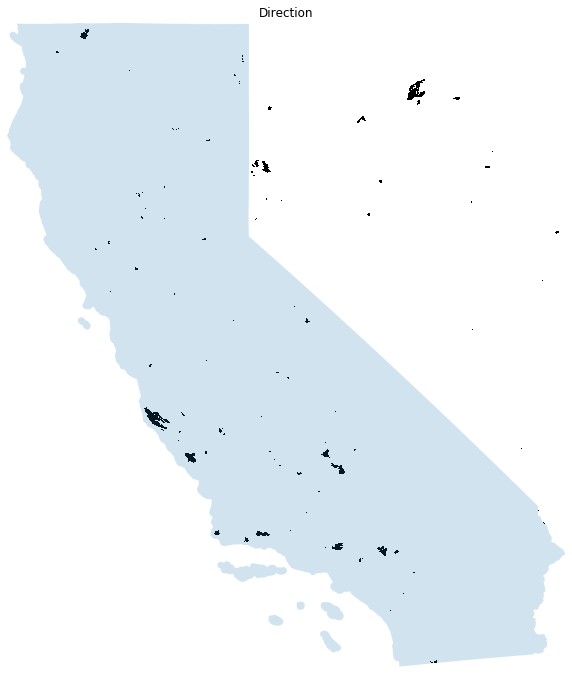

In [111]:
fig,ax = plt.subplots(figsize=(10,16))
ep.plot_bands(diryr_reproj_crop,
              extent = diryr_reproj_extent,
              cmap='Greys',
              title = 'Direction',
              scale=False,
              ax=ax,
              cbar=False)

CA_gdf.plot(ax=ax,alpha=0.2)
ax.set_axis_off()
plt.show()

In [301]:
vals = diryr_reproj_crop[0][diryr_reproj_crop[0]>0]
vals

array([5, 5, 4, ..., 4, 4, 4])

In [95]:
print(type(vals),vals.shape)
stats.describe(vals)

<class 'numpy.ndarray'> (18878,)


DescribeResult(nobs=18878, minmax=(1, 8), mean=4.827788960694989, variance=4.573986433819962, skewness=0.01438966604151448, kurtosis=-0.8866531007320164)

##### Transform Ignition and polygons of final fire sizes to CA CRS

In [109]:
# transform CRS
ign2 = ign_gdf.to_crs(dst_crs)
poly2 = poly_gdf.to_crs(dst_crs)

C:\DDRIVE\ProgramData\Anaconda3\envs\wildfire\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\DDRIVE\ProgramData\Anaconda3\envs\wildfire\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [114]:
# set area to crop to
bb = CA_gdf.envelope

In [116]:
# Crop polygons of final fire sizes using geopandas overlay
df2 = gpd.GeoDataFrame(gpd.GeoSeries(bb),columns=['geometry'])
poly2crop = gpd.overlay(df2,poly2,how='intersection')

In [117]:
# Use dataframe slicing for the ignition point data.
xmin,ymin,xmax,ymax=CA_gdf.total_bounds
ign2crop = ign2.cx[xmin:xmax,ymin:ymax]

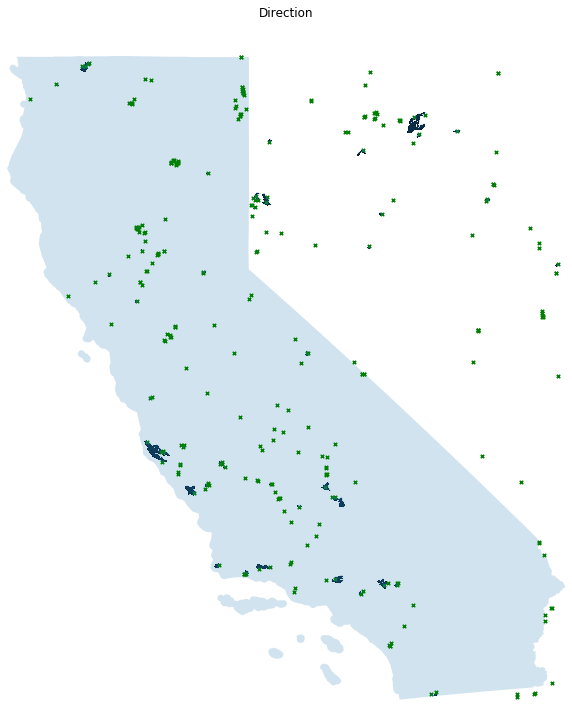

In [131]:
fig,ax = plt.subplots(figsize=(10,16))
ep.plot_bands(diryr_reproj_crop,
              extent = diryr_reproj_extent,
              cmap='Greys',
              title = 'Direction',
              scale=False,
              ax=ax,
              cbar=False)

CA_gdf.plot(ax=ax, alpha=0.2)
ign2crop.plot(ax=ax,marker='x',color='green',markersize=12)
poly2crop.plot(ax=ax,alpha=0.4)
ax.set_axis_off()
plt.show()

#### Create new bounding box for smaller section of CA and convert CRS
Repeat above process for cropping

In [155]:
# Set source CRS - this is the google maps CRS
bb_gdf_orig.crs = {'init':'epsg:4326'}
print(bb_gdf_orig.crs)

{'init': 'epsg:4326'}


In [165]:
# Create bounding box polygon from lat long pulled from Gmaps
from shapely.geometry import Polygon
bb_long = [-122, -119.912,-119.912,-122,-122 ]
bb_lat = [36.8, 36.8, 35.06, 35.06,36.8]
bb_poly = Polygon(zip(bb_long,bb_lat))
bb_gdf2 = gpd.GeoDataFrame(index=[0],crs=bb_gdf_orig.crs,geometry = [bb_poly])
print(bb_gdf2.geometry)

0    POLYGON ((-122.00000 36.80000, -119.91200 36.8...
Name: geometry, dtype: geometry


In [167]:
# Change CRS of polygon to match other work here
bb_gdf2 = bb_gdf2.to_crs(epsg=3857)
bb_gdf2

C:\DDRIVE\ProgramData\Anaconda3\envs\wildfire\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,geometry
0,"POLYGON ((-13580977.877 4411265.910, -13348542..."


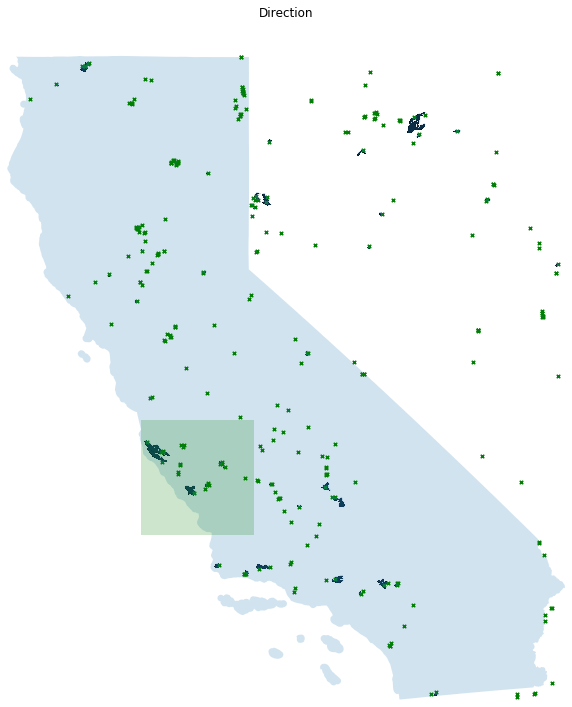

In [168]:
# Plotting
fig,ax = plt.subplots(figsize=(10,16))
ep.plot_bands(diryr_reproj_crop,
              extent = diryr_reproj_extent,
              cmap='Greys',
              title = 'Direction',
              scale=False,
              ax=ax,
              cbar=False)

CA_gdf.plot(ax=ax, alpha=0.2)
ign2crop.plot(ax=ax,marker='x',color='green',markersize=12)
poly2crop.plot(ax=ax,alpha=0.4)
bb_gdf2.plot(ax=ax,color='green',alpha=0.2)
ax.set_axis_off()
plt.show()

#### Convert CRS for remaining raster files

In [180]:
# Raster Data opened by rio 
#speedyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_speed_yearly_2016.tif')
#dobyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_day_of_burn_yearly_2016.tif')
#firelineyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_fire_line_yearly_2016.tif')
print('speedyr bounds =',speedyr.bounds)
print('dobyr bounds =',dobyr.bounds)
print('firelineyr bounds =',firelineyr.bounds)

speedyr bounds = BoundingBox(left=-20015109.354, bottom=-6671703.118005, right=17791208.314677987, top=7783653.637666)
dobyr bounds = BoundingBox(left=-20015109.354, bottom=-6671703.118005, right=17791208.314677987, top=7783653.637666)
firelineyr bounds = BoundingBox(left=-20015109.354, bottom=-6671703.118005, right=17791208.314677987, top=7783653.637666)


In [60]:
# Set destination CRS
dst_crs = bb_gdf2.crs

In [185]:
tifs = [(speedyr,'speed'),(dobyr,'dob'),(firelineyr,'fireline')]

In [187]:
# Commented out this whole box because files have been saved already NEXT TIME - ADD COMPRESSION - 
# FILES WERE HUGE (see commented line below) OR reproject to new array, then write out with compression
# %%time
# for tif in tifs:
#     file,name = tif
    
#     # Calculate the transform using the rasterio warp function
#     transform,width,height = calculate_default_transform(file.crs,dst_crs,file.width,file.height,*file.bounds)
    
#     # Set the new meta data for the projected raster file
#     kwargs = file.meta.copy()
#     kwargs.update({'crs':dst_crs,
#                   'transform':transform,
#                   'width':width,
#                   'height':height
#                   #compress:'lzw'
#                   })
    
#     # Filename for writing out to
#     filestring = '../data/GlobalFire2016/Global_fire_atlas_' + name + '_yearly_2016_reproj.tif'
    
#     # write the new raster file by using the rasterio reproject function
#     with rio.open(filestring,'w',**kwargs) as dst:
#         for i in range(1, file.count + 1):
#             reproject(
#                 source = rio.band(file,i),
#                 destination=rio.band(dst,i),
#                 file_transform = file.transform,
#                 file_crs = file.crs,
#                 dst_transform = transform,
#                 dst_crs = dst_crs,
#                 resampling=Resampling.nearest)  

In [302]:
# Close all the previous readers
diryr.close()
dobyr.close()
firelineyr.close()
speedyr.close()

#### Crop to smaller bounding box - Toy Set

In [303]:
# Check CRSs all match
print('ignition CRS', ign2.crs)
print('final polygon CRS', poly2.crs)
print('bounding box CRS', bb_gdf2.crs)

ignition CRS {'init': 'epsg:3857'}
final polygon CRS {'init': 'epsg:3857'}
bounding box CRS {'init': 'epsg:3857', 'no_defs': True}


##### First the ignition points to get fire numbers and then final fire sizes and dbf data

In [304]:
print('bounding box extents', bb_gdf2.total_bounds)

bounding box extents [-13580977.87677938   4172037.89674901 -13348542.78000302
   4411265.91026269]


In [305]:
# Crop Ignition Data
xmin2,ymin2,xmax2,ymax2=bb_gdf2.total_bounds
ign2crop2 = ign2.cx[xmin2:xmax2,ymin2:ymax2]

In [306]:
print(ign2crop2.shape, ign2.shape)

(22, 2) (887221, 2)


In [307]:
fires = ign2crop2['fire_ID'].values

In [308]:
poly2crop2 = poly2.loc[poly2['fire_ID'].isin(fires)]

In [309]:
print(poly2crop2.shape, poly2.shape)

(22, 2) (887251, 2)


In [310]:
featurescrop2 = features1.loc[features1['fire_ID'].isin(fires)]

In [342]:
featurescrop2.head()

,fire_ID,latitude,longitude,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_s,landcover,landcover_s,tile_ID
139,140,36.4604,-121.894,447.39,196.31,2016-07-21,203,2016-09-17,261,59,7.58,12.96,1.89,4,southeast,8,Woody savannas,h08v05
140,141,36.3271,-121.592,23.79,30.56,2016-09-15,259,2016-09-23,267,9,2.64,4.42,3.04,8,northwest,8,Woody savannas,h08v05
141,142,36.3188,-121.594,39.23,36.11,2016-09-15,259,2016-09-25,269,11,3.57,5.14,2.55,4,southeast,8,Woody savannas,h08v05
142,143,36.3146,-121.629,18.86,24.08,2016-09-17,261,2016-09-29,273,13,1.45,2.32,2.64,4,southeast,8,Woody savannas,h08v05
145,146,36.4188,-121.259,1.93,8.33,2016-04-09,100,2016-04-14,105,6,0.32,0.69,1.57,4,southeast,10,Grasslands,h08v05


In [343]:
ign2crop2.head()

,fire_ID,geometry
139,140,POINT (-13569190.649 4364164.207)
140,141,POINT (-13535572.325 4345725.240)
141,142,POINT (-13535852.045 4344573.853)
142,143,POINT (-13539733.596 4343998.206)
145,146,POINT (-13498502.587 4358398.631)


In [338]:
%%time
#pickle out the ignition points and dbf
with open('../data/GlobalFire2016/Global_fire_atlas_ignitioncrop.pickle','wb') as f:
    pickle.dump(ign2crop2,f,pickle.HIGHEST_PROTOCOL)
with open('../data/GlobalFire2016/Global_fire_atlas_datacrop.pickle','wb') as f:
    pickle.dump(featurescrop2,f,pickle.HIGHEST_PROTOCOL)

Wall time: 18 ms


##### Crop the rasters

In [256]:
# Open the new reprojected geotiffs
diryr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016_reproj.tif')
speedyr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_speed_yearly_2016_reproj.tif')
dobyr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_dob_yearly_2016_reproj.tif')
firelineyr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_fireline_yearly_2016_reproj.tif')

In [311]:
# Crop extent: bb_gdf2 - crop to the small box, which should work now that both raster 
# and shapefile are on the same CRS
print('crop extent crs = ', bb_gdf2.crs)
print('direction tiff crs = ', diryr_reproj.crs)
print('speed tiff crs = ', speedyr_reproj.crs)
print('day of burn tiff crs = ', dobyr_reproj.crs)
print('fireline tiff crs = ', firelineyr_reproj.crs)

crop extent crs =  {'init': 'epsg:3857', 'no_defs': True}
direction tiff crs =  EPSG:3857
speed tiff crs =  EPSG:3857
day of burn tiff crs =  EPSG:3857
fireline tiff crs =  EPSG:3857


In [313]:
def crop_tif(tif_reproj,boundingbox):
    """function to crop the reprojected tiffs by the bounding box (shapefile)"""
    
    tif_reproj_crop,tif_reproj_crop_meta = es.crop_image(tif_reproj,boundingbox)
    print("cropped data", tif_reproj_crop.shape)
    print("original data", tif_reproj.shape)
    print("meta", tif_reproj_crop_meta)
       
    return(tif_reproj_crop, tif_reproj_crop_meta)

In [314]:
%%time
diryr_reproj_crop,diryr_reproj_crop_meta = crop_tif(diryr_reproj,bb_gdf2)
speedyr_reproj_crop,speedyr_reproj_crop_meta = crop_tif(speedyr_reproj,bb_gdf2)
dobyr_reproj_crop,dobyr_reproj_crop_meta = crop_tif(dobyr_reproj,bb_gdf2)
firelineyr_reproj_crop,firelineyr_reproj_crop_meta = crop_tif(firelineyr_reproj,bb_gdf2)

cropped data (1, 470, 456)
original data (38174, 78580)
meta {'driver': 'GTiff', 'dtype': 'int32', 'nodata': -9999.0, 'width': 456, 'height': 470, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(509.9863732168427, 0.0, -13581080.848881941,
       0.0, -509.9928633270912, 4411268.819459678)}
cropped data (1, 470, 456)
original data (38174, 78580)
meta {'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 456, 'height': 470, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(509.9863732168427, 0.0, -13581080.848881941,
       0.0, -509.9928633270912, 4411268.819459678)}
cropped data (1, 470, 456)
original data (38174, 78580)
meta {'driver': 'GTiff', 'dtype': 'int32', 'nodata': -9999.0, 'width': 456, 'height': 470, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(509.9863732168427, 0.0, -13581080.848881941,
       0.0, -509.9928633270912, 4411268.819459678)}
cropped data (1, 470, 456)
original data (38174, 78580)
meta {'driver': 'GTiff', 'dtyp

In [318]:
vals = firelineyr_reproj_crop[0][firelineyr_reproj_crop[0]>0]
vals

array([208, 208, 208, ..., 232, 231, 231])

In [321]:
diryr_reproj.close()
speedyr_reproj.close()
dobyr_reproj.close()
firelineyr_reproj.close()

In [323]:
# Write these out to smaller tiffs
with rio.open('../data/GlobalFire2016/Global_fire_atlas_dircrop.tif','w',**diryr_reproj_crop_meta) as dst:
    dst.write(diryr_reproj_crop)
with rio.open('../data/GlobalFire2016/Global_fire_atlas_speedcrop.tif','w',**speedyr_reproj_crop_meta) as dst:
    dst.write(speedyr_reproj_crop)
with rio.open('../data/GlobalFire2016/Global_fire_atlas_dobcrop.tif','w',**dobyr_reproj_crop_meta) as dst:
    dst.write(dobyr_reproj_crop)
with rio.open('../data/GlobalFire2016/Global_fire_atlas_firelinecrop.tif','w',**firelineyr_reproj_crop_meta) as dst:
    dst.write(firelineyr_reproj_crop)

#### Create a new tiff with fire_ID as the value
Determine if a raster pixel is in a fire polygon and create a new tiff with fire_ID as the value

In [324]:
# From https://gis.stackexchange.com/questions/151339/rasterize-a-shapefile-with-geopandas-or-fiona-python
polys = poly2crop2
rst_fn = '../data/GlobalFire2016/template.tif'
out_fn = '../data/GlobalFire2016/fireid.tif'

In [325]:
rst = rio.open(rst_fn)
metaout = rst.meta.copy()
metaout.update(compress='lzw')

In [327]:
with rio.open(out_fn, 'w+',**metaout) as out:
    out_arr = out.read(1)
    
    shapes = ((geom,value) for geom,value in zip(polys.geometry,polys.fire_ID))
    
    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1,burned)

In [334]:
fireid = rio.open('../data/GlobalFire2016/fireid.tif')
print(fireid.meta)

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': -9999.0, 'width': 456, 'height': 470, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(509.9863732168427, 0.0, -13581080.848881941,
       0.0, -509.9928633270912, 4411268.819459678)}


In [332]:
fireid_array = fireid.read()

In [333]:
fireid_array.shape

(1, 470, 456)

In [344]:
print(fireid_array)

[[[-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  ...
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]]]


In [336]:
vals = fireid_array[0][fireid_array[0]>0]
vals

array([140, 140, 140, ..., 189, 189, 189])

In [341]:
len(vals)

4855

#### Yearly TIFFs

In [28]:
from rasterio.windows import Window

In [29]:
%%time
diryr = rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016.tif')
speedyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_speed_yearly_2016.tif')
dobyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_day_of_burn_yearly_2016.tif')
firelineyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_fire_line_yearly_2016.tif')

Wall time: 116 ms


In [ ]:
tifs = [diryr,speedyr,dobyr,firelineyr]

In [ ]:
for tif in tifs:
    print("name = ",tif.name)
    print("resolution of a pixel in units of coord reference system = ",tif.res)
    print("Image Structure tags =",tif.tags(ns='IMAGE_STRUCTURE'))
    print("tags =",tif.tags())
    print(tif.shape)
    print(tif.bounds)
    print("number of layers = ",tif.count)
    print("number of bands =", tif.indexes)
    print(tif.meta)
    print("\n\n")

In [34]:
print(diryr.meta)
#customcrs = diryr.meta

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': -9999.0, 'width': 81600, 'height': 31200, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(463.3127165279165, 0.0, -20015109.354,
       0.0, -463.3127165279167, 7783653.637666)}


In [35]:
print(diryr.crs)

PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [36]:
customcrs = diryr.crs

#### Convert Lat/Long to CRS

From StackExchange:

You need to transform your points to the coordinate system of the raster. You could warp the raster to your points' coordinate system but warping rasters is a bit messy. (for R but should be similar in python)

https://gis.stackexchange.com/questions/200417/very-basic-question-on-extracting-data-from-tif-raster-layer-in-r-projection-n

In [9]:
# Our desired 'fire' from the shapefile
fire

,fire_ID,latitude,longitude,size,geometry,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_s,landcover,landcover_s,tile_ID,ignition_pt
34569,34570,56.6604,-111.41,1547.32,"POLYGON ((-110.20500 56.80417, -110.19739 56.8...",2016-05-01,122,2016-05-29,150,29,53.36,68.3,13.21,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-111.41070 56.66044)


In [10]:
fire.crs

{'init': 'epsg:4326'}

In [11]:
# Global Fire Atlas projection Coordinate Reference System (from website)
gfacrs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs" 

In [12]:
fire2 = fire.to_crs(gfacrs)
fire2

C:\DDRIVE\ProgramData\Anaconda3\envs\wildfire\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,fire_ID,latitude,longitude,size,geometry,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_s,landcover,landcover_s,tile_ID,ignition_pt
34569,34570,56.6604,-111.41,1547.32,"POLYGON ((-6709231.448 6316342.264, -6708768.1...",2016-05-01,122,2016-05-29,150,29,53.36,68.3,13.21,3,east,1,Evergreen Needleleaf forest,h11v03,POINT (-111.41070 56.66044)


In [17]:
fire2.geometry.name

'geometry'

In [19]:
fire2.crs  # Ah that is why you can't convert two columns. because when you convert one column
# then the entire dataframe thinks it is now in the new CRS

'+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs'

# EDA Stats and Plots

## Raster Data

In [91]:
# Opening the 4 raster files in toy data (not including DOB)
with rio.open('../toydata/Global_fire_atlas_dircrop.tif') as f1:
    direction = f1.read(1).astype(float)
with rio.open('../toydata/Global_fire_atlas_firelinecrop.tif') as f2:
    fireline = f2.read(1).astype(float)
with rio.open('../toydata/Global_fire_atlas_speedcrop.tif') as f3:
    speed = f3.read(1)
with rio.open('../toydata/fireid.tif') as f4:
    fireid = f4.read(1).astype(float)

In [92]:
rasters = {'direction':direction,'fireline':fireline,'speed':speed,'fireid':fireid}

### Fire Data Heatmaps

In [64]:
def plot_rasters(rasters):
    """ Plot all the fire data rasters for 2016 as heatmaps"""
    fig = plt.figure(figsize = (20,4))
    fig.suptitle('Bounded Fire Data showing Sparsity 2016')
    fig.subplots_adjust(hspace=0.4)
    i=1
    for key,data in rasters.items():
        ax = fig.add_subplot(1,4,i)
        sns.heatmap(data)
        ax.set_title(key)
        i+=1
    plt.savefig('HeatmapFireData.jpg')
    plt.show()

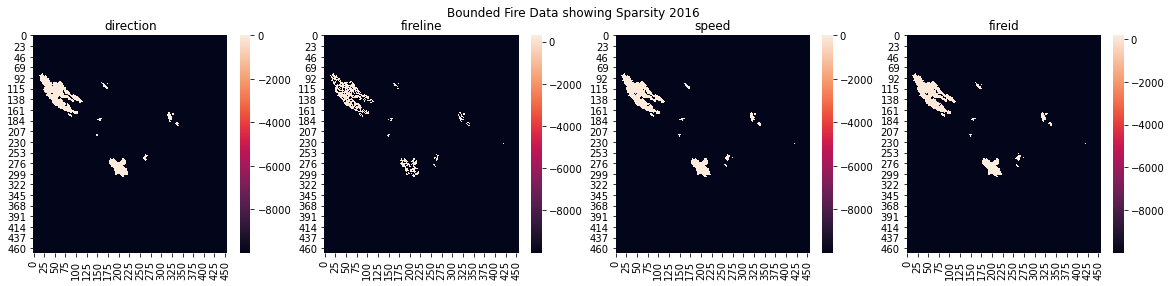

In [65]:
# Visual of sparsity
plot_rasters(rasters)

### Fire Data Statistics

In [96]:
# First create 1D array from 2D rasters
dir1 = copy.deepcopy(direction)
fl1 = copy.deepcopy(fireline)
spd1 = copy.deepcopy(speed)
fid1 = copy.deepcopy(fireid)

In [97]:
dir1 = np.ravel(dir1)
fl1 = np.ravel(fl1)
spd1 = np.ravel(spd1)
fid1 = np.ravel(fid1)

In [111]:
onedim = {'direction':dir1,'fireline':fl1,'speed':spd1,'fireid':fid1}

In [106]:
totalpixels = dir1.shape[0]

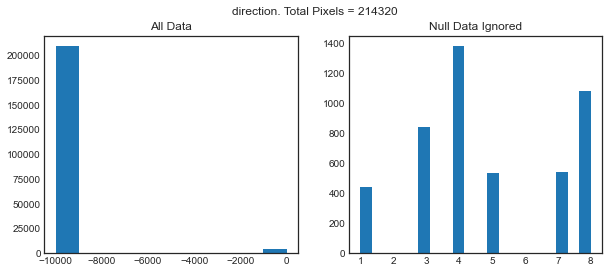

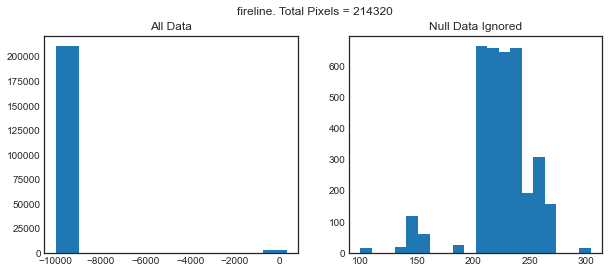

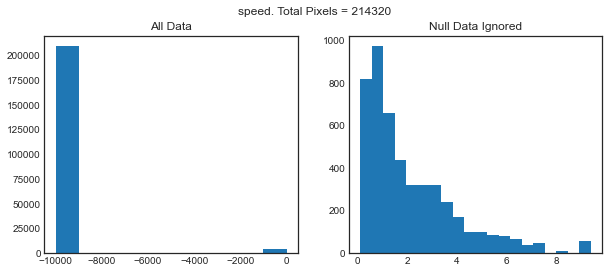

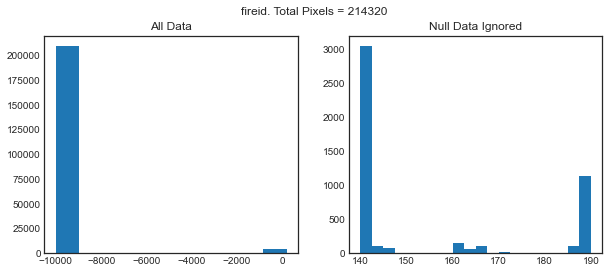

In [114]:
for name,data in onedim.items():
    fig = plt.figure(figsize = (10,4))
    fig.suptitle(f"{name}. Total Pixels = {totalpixels}")
    plt.style.use('seaborn-white')
    ax = fig.add_subplot(1,2,1)
    plt.hist(data)
    ax.set_title("All Data")
    ax = fig.add_subplot(1,2,2)
    plt.hist(data[data>-10],bins=20)
    ax.set_title("Null Data Ignored")
    plt.show()

# Setup